<a href="https://colab.research.google.com/github/emiliomercuri/ciencia_dados/blob/main/aulas/2023_11_13_Aula_09_pyTorch_workflow_putting_it_all_together_(parte_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6. Putting it all together

Let's go back through the steps we've done and see it all in one place

In [ ]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

#Check PyTorch Version
torch.__version__

'2.1.0+cu118'

Create device-agnostic code

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [ ]:
# Setup device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 6.1 Data

In [ ]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and Y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[: 10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Faz um gráfico dos dados de treinamento, teste e compara com as predições
  """
  plt.figure(figsize=(6,4))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b',s=3,label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='g',s=3,label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot predictions  if they exist
    plt.scatter(test_data, predictions, c='r', s=3, label="Predictions")

  # Show de legend
  plt.legend(prop={"size":10})

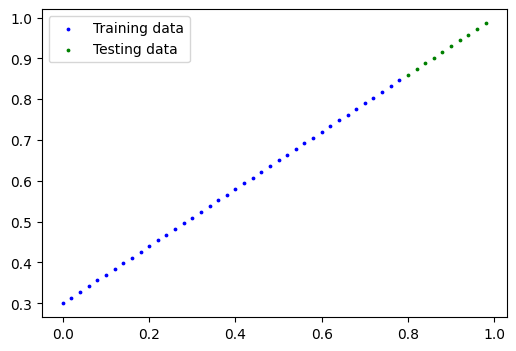

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch Linear Model

In [ ]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called: linear transform, a linear layer
    self.linear_layer = nn.Linear(in_features=1,  # input with size 1
                                  out_features=1) # output with size 1

  def forward(self, x: torch.Tensor) -> torch.Tensor: # x é o input, e o modelo vai retornar um tensor como saída
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
list(model_1.parameters())

[Parameter containing:
 tensor([[0.7645]], requires_grad=True),
 Parameter containing:
 tensor([0.8300], requires_grad=True)]

In [ ]:
# The next() function returns the next item in an iterator.
next(model_1.parameters())

Parameter containing:
tensor([[0.7645]], requires_grad=True)

In [ ]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

### 6.3 Training the model

For training we need:
* Loss function (measure how wrong or model is)
* Optimizer (optimizes the parameters of our model)
* Training loop
* Testing loop

In [ ]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01) # SGD = Stochastic Gradient Descent

In [ ]:
# Let's write a training/testing loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred,y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
weight, bias # parâmetros ideais

(0.7, 0.3)

### 6.4 Making and evaluating predictions

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

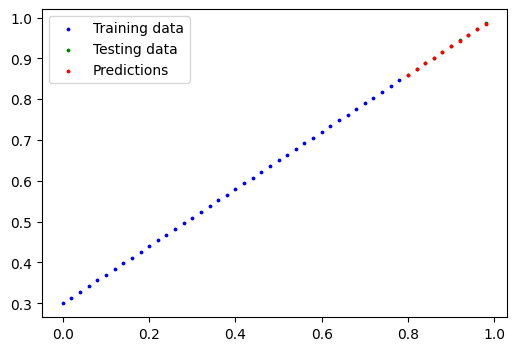

In [ ]:
# Check out our model predictions visually
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and loading a trained model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#MODEL_SAVE_PATH

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Load a PyTorch

# Create a new instance of linear regression model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')